In [3]:
# Step 1: Import libraries
import pandas as pd

# Step 2: Load your dataset
# Replace 'your_file.csv' with your actual file name
df = pd.read_csv('Data_FRP.csv')

# Step 3: Show basic info about the dataset
print("🔍 Dataset Info:")
print(df.info())

# Step 4: Show first few rows
print("\n📌 First 5 Rows:")
print(df.head())

# Step 5: Show column names
print("\n🧩 Column Names:")
print(df.columns.tolist())

# Step 6: Show summary statistics
print("\n📊 Summary Statistics:")
print(df.describe())

# Step 7: Check for missing values
print("\n❗ Missing Values:")
print(df.isnull().sum())


🔍 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225297 entries, 0 to 225296
Data columns (total 46 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  225297 non-null  object 
 1   longitude             225297 non-null  float64
 2   latitude              225297 non-null  float64
 3   Integrated_FRP        225297 non-null  float64
 4   Max_FRP               225297 non-null  float64
 5   state                 225297 non-null  object 
 6   Precipitation         225297 non-null  float64
 7   Air_Temperature_Max   225297 non-null  float64
 8   Air_Temperature_Mean  225297 non-null  float64
 9   Wind_Speed            225297 non-null  float64
 10  Wind_Direction        225297 non-null  float64
 11  Biomass               225297 non-null  float64
 12  Solar_Radiance        225297 non-null  float64
 13  Soil_Moisture         225297 non-null  float64
 14  LST_Day_Max           225297 non-nul

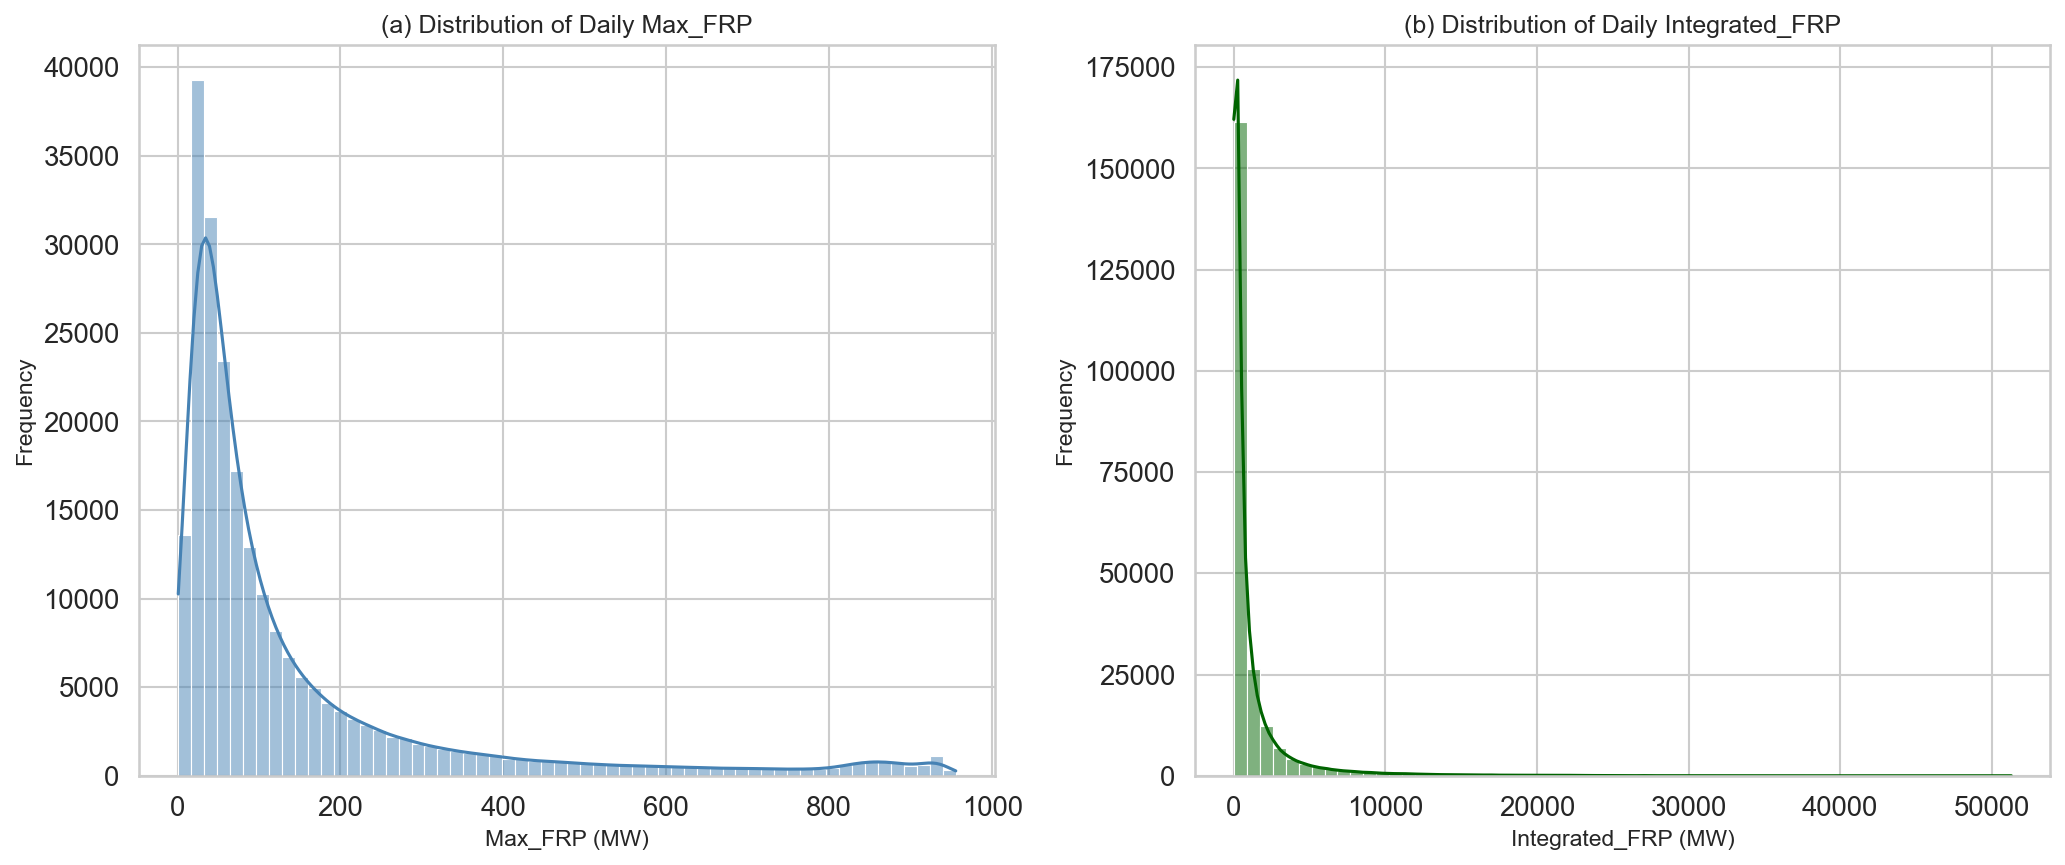

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("Data_FRP.csv")

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=150)

# Plot Max_FRP
sns.histplot(
    data["Max_FRP"], bins=60, kde=True, color="steelblue", edgecolor=None, ax=axes[0]
)
axes[0].set_title("(a) Distribution of Daily Max_FRP", fontsize=12)
axes[0].set_xlabel("Max_FRP (MW)", fontsize=11)
axes[0].set_ylabel("Frequency", fontsize=11)

# Plot Integrated_FRP
sns.histplot(
    data["Integrated_FRP"], bins=60, kde=True, color="darkgreen", edgecolor=None, ax=axes[1]
)
axes[1].set_title("(b) Distribution of Daily Integrated_FRP", fontsize=12)
axes[1].set_xlabel("Integrated_FRP (MW)", fontsize=11)
axes[1].set_ylabel("Frequency", fontsize=11)

# Final layout
plt.tight_layout()
plt.savefig("frp_distribution_dual_corrected.png", dpi=300)
plt.show()


In [29]:
# Show statistics as table
summary = df[['Max_FRP', 'Integrated_FRP']].describe().T
summary = summary.rename(columns={
    'mean': 'Mean', 'std': 'Std Dev', 'min': 'Min', '25%': 'Q1',
    '50%': 'Median', '75%': 'Q3', 'max': 'Max'
})

print("\n Basic Statistics:")
print(summary[['Mean', 'Std Dev', 'Min', 'Q1', 'Median', 'Q3', 'Max']])


 Basic Statistics:
                       Mean      Std Dev   Min      Q1   Median       Q3  \
Max_FRP          144.954226   192.085868  0.87  34.250   68.455   160.84   
Integrated_FRP  1141.078905  2553.633974  0.87  77.985  289.405  1022.91   

                     Max  
Max_FRP           955.43  
Integrated_FRP  51284.18  


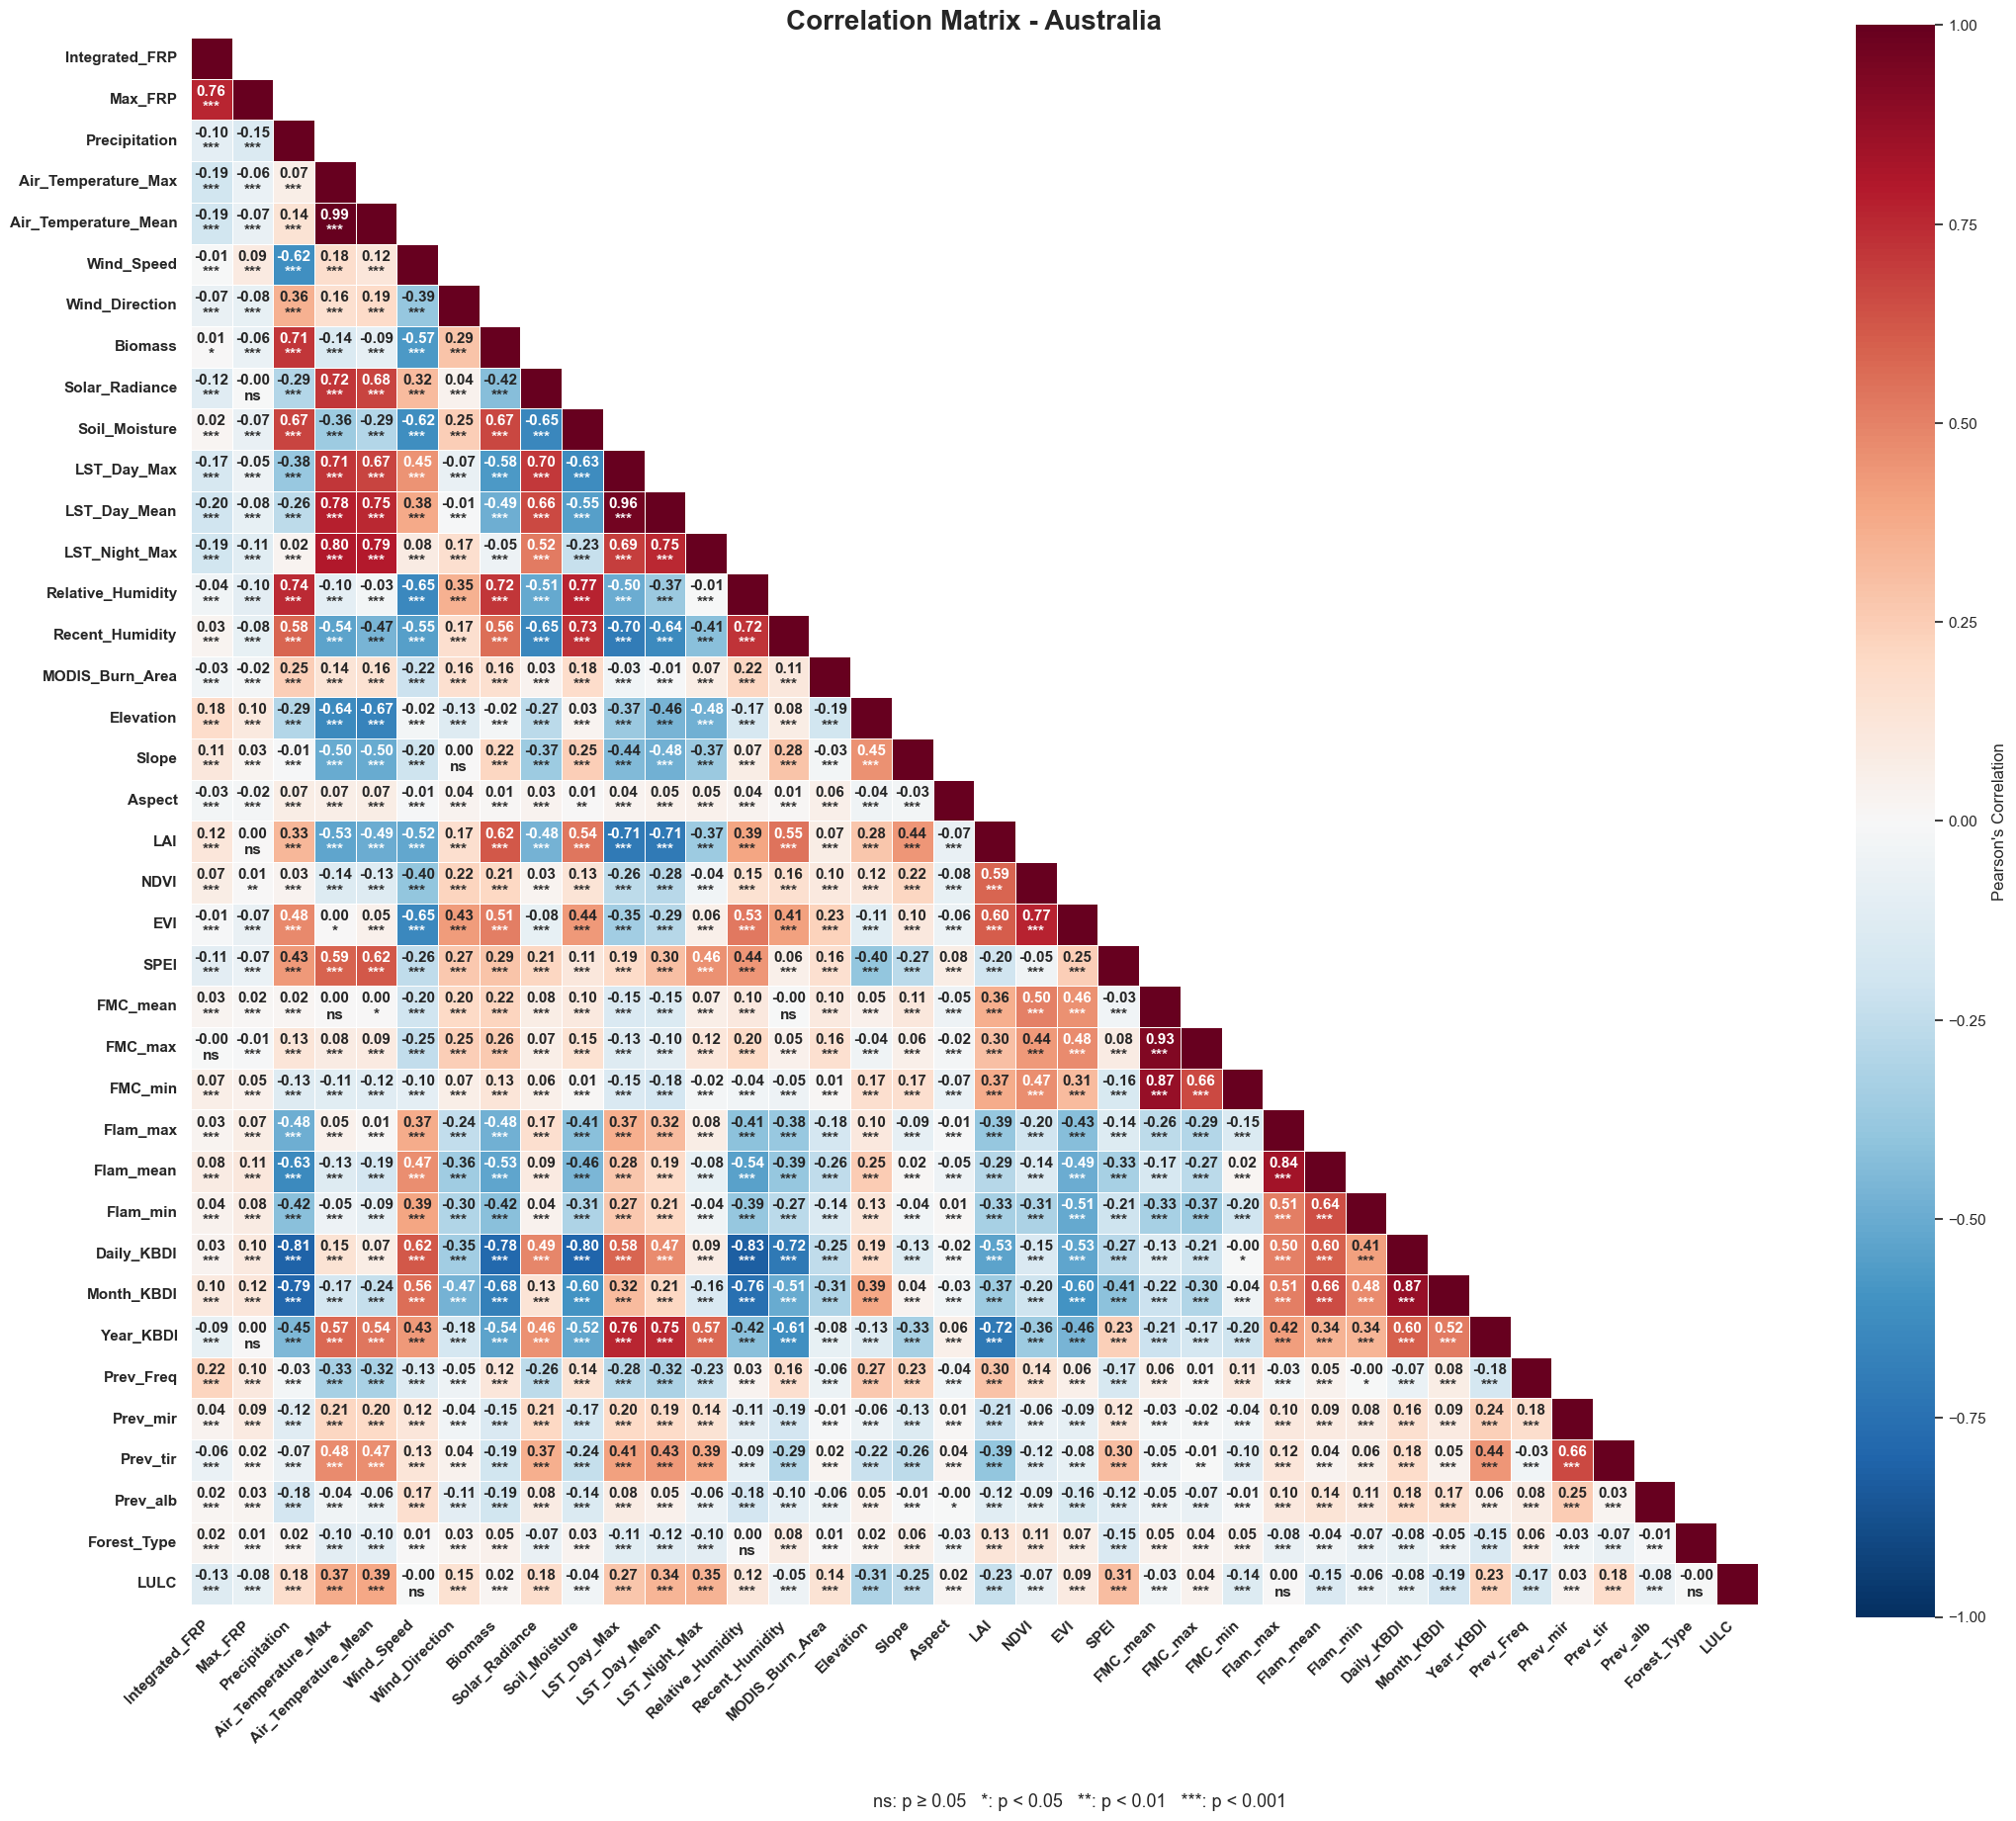

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

# Load the dataset
file_path = "Data_FRP.csv"
data = pd.read_csv(file_path)

# Select numeric columns
columns_of_interest = [
    'Integrated_FRP', 'Max_FRP', 'Precipitation', 'Air_Temperature_Max', 'Air_Temperature_Mean', 'Wind_Speed',
    'Wind_Direction', 'Biomass', 'Solar_Radiance', 'Soil_Moisture', 'LST_Day_Max', 'LST_Day_Mean',
    'LST_Night_Max', 'LST_Night_Mean', 'Relative_Humidity', 'Recent_Humidity', 'MODIS_Burn_Area', 'Elevation',
    'Slope', 'Aspect', 'LAI', 'NDVI', 'EVI', 'SPEI', 'FMC_mean', 'FMC_max', 'FMC_min', 'Flam_max', 'Flam_mean',
    'Flam_min', 'Daily_KBDI', 'Month_KBDI', 'Year_KBDI', 'Prev_Freq', 'Prev_mir', 'Prev_tir', 'Prev_alb',
    'Forest_Type', 'LULC'
]
existing_columns = [col for col in columns_of_interest if col in data.columns]
filtered_data = data[existing_columns].copy()

# Encode categorical columns
for col in ['Forest_Type', 'LULC']:
    if col in filtered_data.columns:
        le = LabelEncoder()
        filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))

# Fill missing values
filtered_data.fillna(filtered_data.mean(), inplace=True)

# Keep numeric only
numeric_data = filtered_data.select_dtypes(include=[np.number])

# Correlation + significance
def corr_with_significance(data):
    corr = data.corr()
    p_vals = pd.DataFrame(np.zeros_like(corr), columns=corr.columns, index=corr.index)
    for row in corr.index:
        for col in corr.columns:
            if row != col:
                try:
                    _, p_val = pearsonr(data[row], data[col])
                except:
                    p_val = np.nan
                p_vals.loc[row, col] = p_val
    return corr, p_vals

correlation_matrix, p_values = corr_with_significance(numeric_data)

# Mask for upper triangle
# Mask for upper triangle excluding diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)


# Significance markers
def significance_marker(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# Annotated matrix with correlation + p-value
annotated_matrix = pd.DataFrame('', index=correlation_matrix.index, columns=correlation_matrix.columns)
for row in correlation_matrix.index:
    for col in correlation_matrix.columns:
        if row != col:
            val = correlation_matrix.loc[row, col]
            p_val = p_values.loc[row, col]
            annotated_matrix.loc[row, col] = f"{val:.2f}\n{significance_marker(p_val)}"
        else:
            annotated_matrix.loc[row, col] = ""

# Plotting
plt.figure(figsize=(22, 20))
sns.set_theme(style="white")

heatmap = sns.heatmap(
    correlation_matrix,
    annot=annotated_matrix,
    fmt="",
    cmap="RdBu_r",
    vmin=-1, vmax=1,  # fixed scale range
    mask=mask,
    square=True,
    linewidths=0.5,
    annot_kws={"size": 11, "weight": "bold", "ha": "center", "va": "center"},
    cbar_kws={
        "label": "Pearson's Correlation",
        "shrink": 0.9,
        "orientation": "vertical"
    }
)

# Style
plt.title("Correlation Matrix - Australia", fontsize=20, weight="bold")
plt.xticks(rotation=45, ha='right', fontsize=11, weight="bold", fontname='Arial')
plt.yticks(rotation=0, fontsize=11, weight="bold", fontname='Arial')
heatmap.figure.axes[-1].tick_params(labelsize=11)

# Significance note
plt.gcf().text(
    0.5, 0.015,
    "ns: p ≥ 0.05   *: p < 0.05   **: p < 0.01   ***: p < 0.001",
    fontsize=13, ha="center", fontname='Arial'
)

# Save
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("correlation_matrix_final.png", dpi=300)
plt.show()


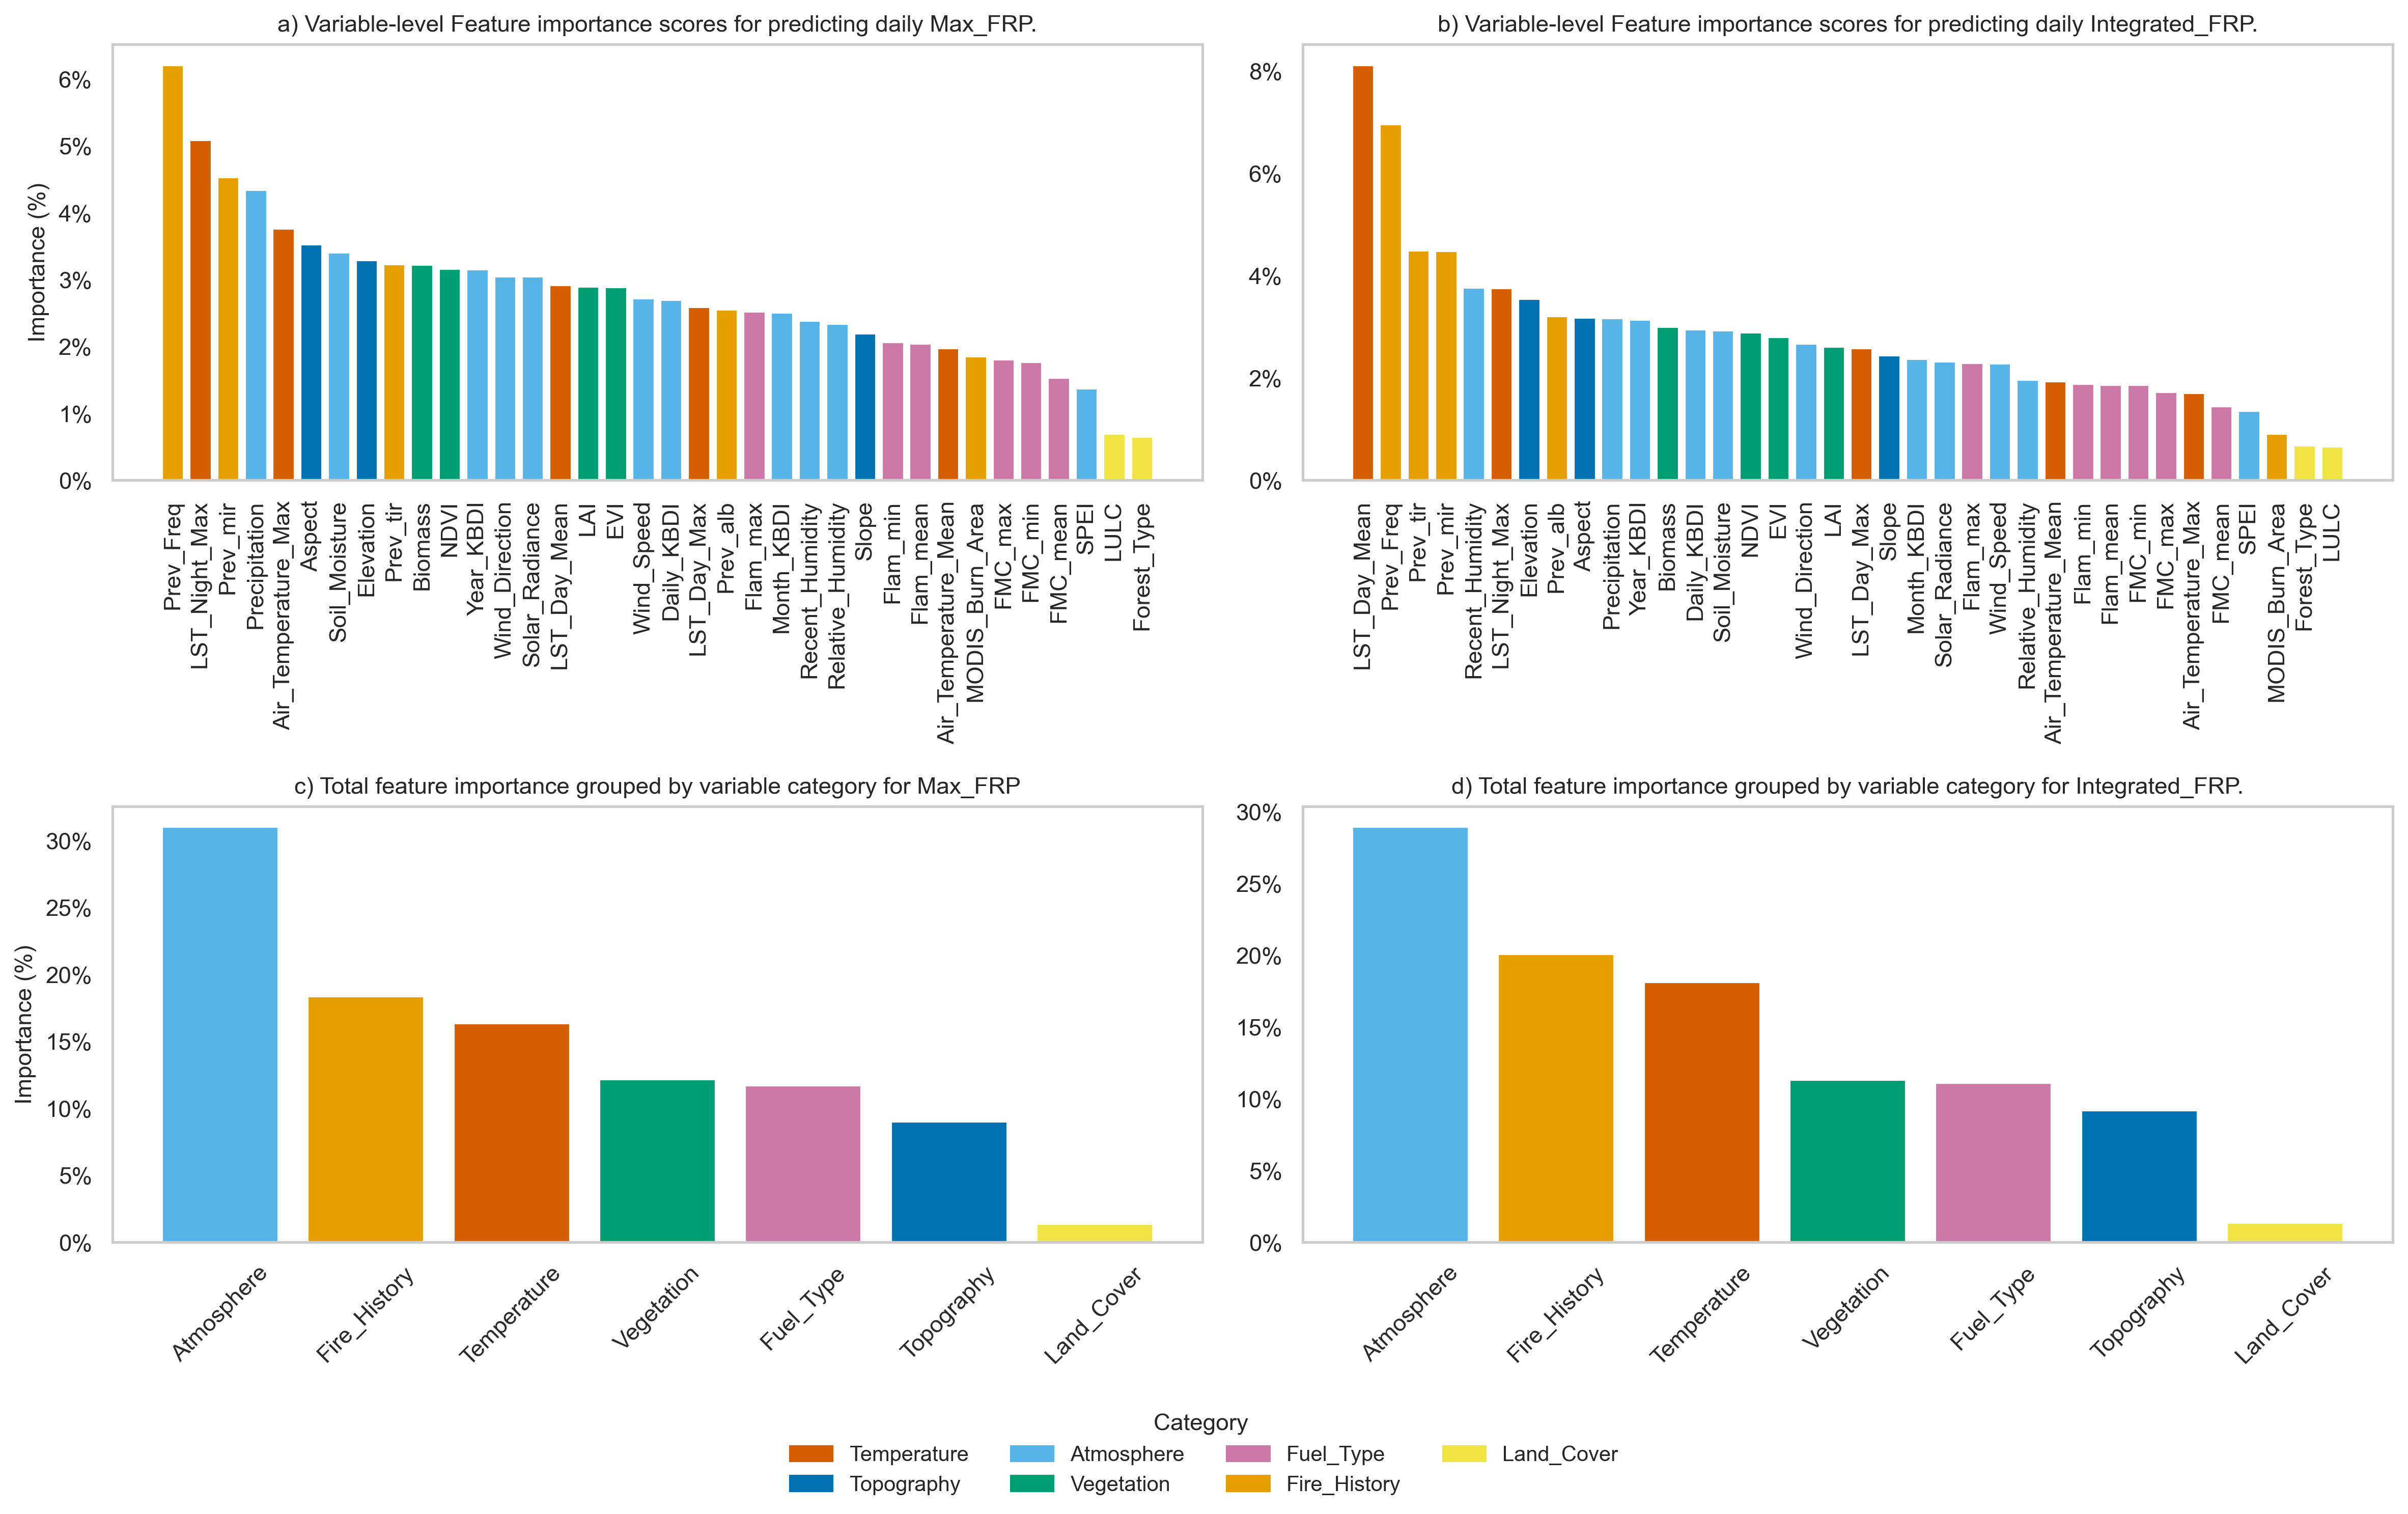

In [39]:
def rf_importance_plot(df, target):
    X = df.drop(columns=[target, 'Date', 'state', 'longitude', 'latitude'], errors='ignore')
    y = df[target]
    for col in X.select_dtypes(include='object').columns:
        X[col] = LabelEncoder().fit_transform(X[col].astype(str))
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter

# ------------------ CATEGORY GROUPS ------------------
variable_groups = {
    'Air_Temperature_Max': 'Temperature', 'Air_Temperature_Mean': 'Temperature',
    'LST_Day_Mean': 'Temperature', 'LST_Day_Max': 'Temperature', 'LST_Night_Max': 'Temperature',
    'Elevation': 'Topography', 'Slope': 'Topography', 'Aspect': 'Topography',
    'Wind_Speed': 'Atmosphere', 'Wind_Direction': 'Atmosphere',
    'Relative_Humidity': 'Atmosphere', 'Recent_Humidity': 'Atmosphere',
    'Solar_Radiance': 'Atmosphere', 'Precipitation': 'Atmosphere',
    'SPEI': 'Atmosphere', 'Daily_KBDI': 'Atmosphere', 'Month_KBDI': 'Atmosphere', 'Year_KBDI': 'Atmosphere',
    'Soil_Moisture': 'Atmosphere',
    'NDVI': 'Vegetation', 'EVI': 'Vegetation', 'LAI': 'Vegetation', 'Biomass': 'Vegetation',
    'Flam_mean': 'Fuel_Type', 'Flam_min': 'Fuel_Type', 'Flam_max': 'Fuel_Type',
    'FMC_mean': 'Fuel_Type', 'FMC_min': 'Fuel_Type', 'FMC_max': 'Fuel_Type',
    'Prev_Freq': 'Fire_History', 'Prev_tir': 'Fire_History', 'Prev_mir': 'Fire_History',
    'Prev_alb': 'Fire_History', 'MODIS_Burn_Area': 'Fire_History',
    'LULC': 'Land_Cover', 'Forest_Type': 'Land_Cover'
}

# ------------------ COLOR PALETTE ------------------
category_colors = {
    'Temperature': '#D55E00',
    'Topography': '#0072B2',
    'Atmosphere': '#56B4E9',
    'Vegetation': '#009E73',
    'Fuel_Type': '#CC79A7',
    'Fire_History': '#E69F00',
    'Land_Cover': '#F0E442',
}

# ------------------ FORMATTER ------------------
def percent_formatter(x, _):
    return f"{int(round(x))}%"

# ------------------ PLOT FUNCTION ------------------
def plot_4_panel_importance(i_frp_csv, max_frp_csv, output_file="Feature_Importance USING RANDOM FOREST.png"):
    i_df = pd.read_csv(i_frp_csv, index_col=0)
    max_df = pd.read_csv(max_frp_csv, index_col=0)

    i_df['Category'] = i_df.index.map(lambda x: variable_groups.get(x, 'Other'))
    max_df['Category'] = max_df.index.map(lambda x: variable_groups.get(x, 'Other'))

    i_df['Importance'] = i_df['0'] / i_df['0'].sum() * 100
    max_df['Importance'] = max_df['0'] / max_df['0'].sum() * 100

    i_df = i_df.sort_values(by='Importance', ascending=False)
    max_df = max_df.sort_values(by='Importance', ascending=False)

    i_cat_df = i_df.groupby('Category')['Importance'].sum().sort_values(ascending=False)
    max_cat_df = max_df.groupby('Category')['Importance'].sum().sort_values(ascending=False)

    fig, axs = plt.subplots(2, 2, figsize=(16, 10), dpi=300)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    font_kwargs = {'fontsize': 11, 'fontname': 'Arial'}

    # Panel A
    axs[0, 0].bar(max_df.index, max_df['Importance'], color=[category_colors[c] for c in max_df['Category']])
    axs[0, 0].set_title("a) Variable-level Feature importance scores for predicting daily Max_FRP.", **font_kwargs)
    axs[0, 0].set_ylabel("Importance (%)", **font_kwargs)
    axs[0, 0].tick_params(axis='x', rotation=90, labelsize=8)
    axs[0, 0].yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    # Panel B
    axs[0, 1].bar(i_df.index, i_df['Importance'], color=[category_colors[c] for c in i_df['Category']])
    axs[0, 1].set_title("b) Variable-level Feature importance scores for predicting daily Integrated_FRP.", **font_kwargs)
    axs[0, 1].tick_params(axis='x', rotation=90, labelsize=8)
    axs[0, 1].yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    # Panel C
    axs[1, 0].bar(max_cat_df.index, max_cat_df.values, color=[category_colors[c] for c in max_cat_df.index])
    axs[1, 0].set_title("c) Total feature importance grouped by variable category for Max_FRP", **font_kwargs)
    axs[1, 0].set_ylabel("Importance (%)", **font_kwargs)
    axs[1, 0].tick_params(axis='x', rotation=45, labelsize=9)
    axs[1, 0].yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    # Panel D
    axs[1, 1].bar(i_cat_df.index, i_cat_df.values, color=[category_colors[c] for c in i_cat_df.index])
    axs[1, 1].set_title("d) Total feature importance grouped by variable category for Integrated_FRP.", **font_kwargs)
    axs[1, 1].tick_params(axis='x', rotation=45, labelsize=9)
    axs[1, 1].yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    # Remove grid from all subplots
    for ax in axs.flat:
        ax.grid(False)
    # Set consistent font for all axis tick labels (x and y)
    for ax in axs.flat:
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontname('Arial')
            label.set_fontsize(11)

    # Legend
    handles = [mpatches.Patch(color=color, label=cat) for cat, color in category_colors.items()
               if cat in i_cat_df.index or cat in max_cat_df.index]
    fig.legend(handles=handles, title="Category ", loc='lower center', ncol=4,
               fontsize=10, title_fontsize=11, frameon=False)

    # Save
    plt.tight_layout(rect=[0, 0.07, 1, 1])
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

# ------------------ RUN ------------------
plot_4_panel_importance("feature_importance_rf_i_FRP.csv", "feature_importance_rf_max_FRP.csv")

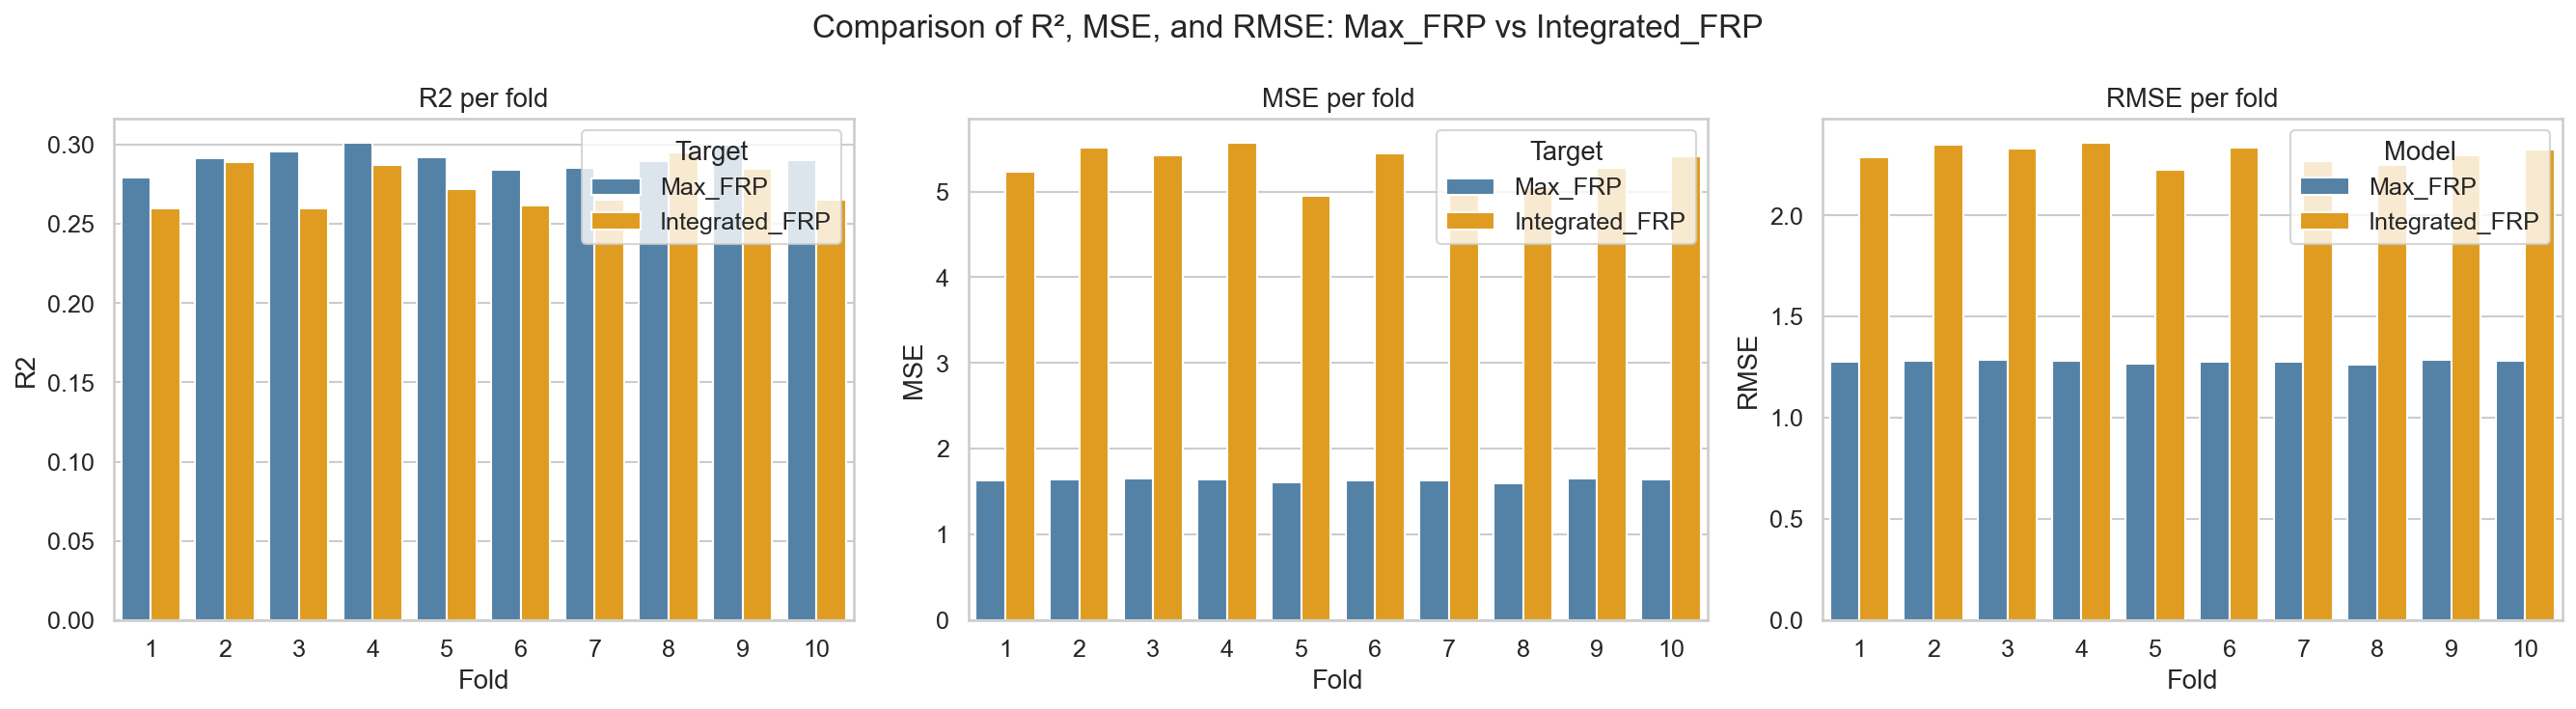

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

# ------------------ LOAD DATA ------------------
data = pd.read_csv("Data_FRP.csv")

# ------------------ ENCODE CATEGORICAL ------------------
for col in data.select_dtypes(include='object').columns:
    data[col] = pd.factorize(data[col])[0]

# ------------------ DEFINE TARGETS ------------------
drop_cols = ["Date", "state", "longitude", "latitude", "Month"]
X = data.drop(columns=drop_cols + ["Max_FRP", "Integrated_FRP"], errors='ignore')
y_max = data["Max_FRP"]
y_int = data["Integrated_FRP"]

# ------------------ CLEAN DATA ------------------
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

# ------------------ SCALE TARGETS ------------------
scaler_max = RobustScaler()
y_max_scaled = scaler_max.fit_transform(y_max.values.reshape(-1, 1)).flatten()

scaler_int = RobustScaler()
y_int_scaled = scaler_int.fit_transform(y_int.values.reshape(-1, 1)).flatten()

# ------------------ XGBOOST SETUP ------------------
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=2.0,
    min_child_weight=5,
    gamma=0.1,
    random_state=42
)

# ------------------ 10-FOLD CV ------------------
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_max, y_test_max = y_max_scaled[train_idx], y_max_scaled[test_idx]
    y_train_int, y_test_int = y_int_scaled[train_idx], y_int_scaled[test_idx]

    # Max_FRP
    model.fit(X_train, y_train_max)
    pred_max = model.predict(X_test)
    results.append({
        "Fold": fold, "Target": "Max_FRP",
        "R2": r2_score(y_test_max, pred_max),
        "MSE": mean_squared_error(y_test_max, pred_max),
        "RMSE": np.sqrt(mean_squared_error(y_test_max, pred_max))
    })

    # Integrated_FRP
    model.fit(X_train, y_train_int)
    pred_int = model.predict(X_test)
    results.append({
        "Fold": fold, "Target": "Integrated_FRP",
        "R2": r2_score(y_test_int, pred_int),
        "MSE": mean_squared_error(y_test_int, pred_int),
        "RMSE": np.sqrt(mean_squared_error(y_test_int, pred_int))
    })

# ------------------ TO DATAFRAME ------------------
results_df = pd.DataFrame(results)

# ------------------ PLOT ------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150)
metrics = ["R2", "MSE", "RMSE"]

# Plot each metric with black edge outlines
for i, metric in enumerate(metrics):
    sns.barplot(
        data=results_df,
        x="Fold", y=metric, hue="Target",
        ax=axes[i],
        palette=["steelblue", "orange"],
        edgecolor='black'  # ✅ Black outline
    )
    axes[i].set_title(f"{metric} per fold")
    axes[i].set_xlabel("Fold")
    axes[i].set_ylabel(metric)
    axes[i].legend().remove()  # Remove local legends

# Title and shared legend
fig.suptitle("Comparison of R², MSE, and RMSE: Max_FRP vs Integrated_FRP", fontsize=15, y=1.08)

# ✅ Shared legend placed right beside the title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Model",
    loc="upper center",
    bbox_to_anchor=(0.92, 1.08),  # Right side aligned with title
    ncol=1,
    fontsize=11, title_fontsize=12, frameon=False
)

# Layout spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("xgboost_frp_comparison_final_clean.png", dpi=300)
plt.show()



In [ ]:
import shap
import matplotlib.pyplot as plt

# -------------------------------
# 📊 SHAP Explainer and Values
# -------------------------------
explainer_max = shap.Explainer(model_max, X_train_max)
explainer_int = shap.Explainer(model_int, X_train_int)

shap_values_max = explainer_max(X_test_max)
shap_values_int = explainer_int(X_test_int)

# -------------------------------
# 🎨 SHAP Summary Plot (Side-by-side)
# -------------------------------
shap.summary_plot(shap_values_max, X_test_max, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Max_FRP")
plt.tight_layout()
plt.savefig("shap_summary_bar_maxfrp.png", dpi=300)
plt.show()

shap.summary_plot(shap_values_int, X_test_int, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Integrated_FRP")
plt.tight_layout()
plt.savefig("shap_summary_bar_integratedfrp.png", dpi=300)
plt.show()

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Custom function to plot one SHAP summary into a subplot
def plot_shap_summary(ax, shap_values, X_test, feature_names, title):
    plt.sca(ax)  # set current axis
    shap.summary_plot(
        shap_values.values,
        features=X_test,
        feature_names=feature_names,
        plot_type="dot",
        max_display=len(feature_names),
        show=False,
        color_bar=False
    )
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlabel("SHAP value", fontsize=12)

# 🔧 Setup figure
fig, axs = plt.subplots(1, 2, figsize=(22, 14), sharey=True)

# 🎯 Plot SHAP for Max_FRP (left)
plot_shap_summary(
    ax=axs[0],
    shap_values=shap_values_max,
    X_test=X_test_max,
    feature_names=X_test_max.columns,
    title="SHAP Summary - Max_FRP"
)

# 🎯 Plot SHAP for Integrated_FRP (right)
plot_shap_summary(
    ax=axs[1],
    shap_values=shap_values_int,
    X_test=X_test_int,
    feature_names=X_test_int.columns,
    title="SHAP Summary - Integrated_FRP"
)

# 🎨 Final touch
plt.tight_layout(pad=4.0)
plt.savefig("f02c_shap_summary_combined_final.png", dpi=300)
plt.show()
